<table>
<tr>
    <td width=25%>
        <img src=" 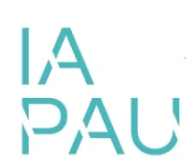" />
    </td>
    <td>
        <center>
            <h1>Meetup machine learning Pau</h1>
        </center>
    </td>
    <td width=15%>
        Paul Gay
    </td>
</tr>
</table>

<br/>
<div id="top"></div>
<center>
    <a style="font-size: 20pt; font-weight: bold">Tester les transformeurs avec Hugging face</a>
<br/>
    Meetup 12 mai 2021 <br>
</center>
<br/>

---

Ce notebook vous propose de manipuler les embedding contextuels. 

Nous allons: 

- Générer du texte à partir des transformeurs
- Obtenir des embedding et nous apercevoir qu'ils sont différents suivant leur contexte.

Nous utiliserons la librairie de la compagnie [Hugging face](https://huggingface.co/) qui donne accès à des modèles pré-entrainées

### Génération de texte 

Nous allons commencer par le modèle [Camembert](https://camembert-model.fr/) appris sur du français par les équipes de Facebook et de l'Inria.

**Note:** Vous pouvez aussi directement essayer [la démo](https://transformer.huggingface.co/) en ligne de la librairie hugginface qui se base sur les même modèles.

In [1]:
from transformers import AutoModelWithLMHead, AutoTokenizer
import torch

In [2]:
model_name = "camembert-base"# try also distilbert-base-cased for english
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelWithLMHead.from_pretrained(model_name)

/home/paul/libs/transformers/src/transformers/models/auto/modeling_auto.py:762: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  FutureWarning,


Vérifions la culture de notre modèle

In [10]:
sequence = f"Jacques Chirac est un {tokenizer.mask_token}"
#sequence = f"Antoine Griezman est un {tokenizer.mask_token}"
#sequence = f"Le camembert, c'est {tokenizer.mask_token}"

input = tokenizer.encode(sequence, return_tensors="pt")
mask_token_index = torch.where(input == tokenizer.mask_token_id)[1]
token_logits = model(input).logits
mask_token_logits = token_logits[0, mask_token_index, :]
top_5_tokens = torch.topk(mask_token_logits, 5, dim=1).indices[0].tolist()
for token in top_5_tokens:
    print(sequence.replace(tokenizer.mask_token, tokenizer.decode([token])))

Jacques Chirac est un ...
Jacques Chirac est un (...)
Jacques Chirac est un homme
Jacques Chirac est un [...]
Jacques Chirac est un président


Utilisons à présent le modèle [GPT2](https://openai.com/blog/better-language-models/), spécialisé dans la génération de texte. À la différence de GPT-3, OpenAI a rendu ce modèle public.

Nous allons appeler ce modèle à partir de l'interface python de hugginface, mais si vous le souhaitez, vous pouvez aussi utiliser [la démo en ligne](https://transformer.huggingface.co/doc/gpt2-large) de hugging face. 

In [8]:
from transformers import TFAutoModelWithLMHead, AutoTokenizer, tf_top_k_top_p_filtering
import tensorflow as tf
tokenizer = AutoTokenizer.from_pretrained("gpt2")
model = TFAutoModelWithLMHead.from_pretrained("gpt2")
sequence = f"Hugging Face is based in DUMBO, New York City, and "
input_ids = tokenizer.encode(sequence, return_tensors="tf")
# get logits of last hidden state
next_token_logits = model(input_ids)[0][:, -1, :]
# filter
filtered_next_token_logits = tf_top_k_top_p_filtering(next_token_logits, top_k=50, top_p=1.0)
# sample
next_token = tf.random.categorical(filtered_next_token_logits, dtype=tf.int32, num_samples=1)
generated = tf.concat([input_ids, next_token], axis=1)
resulting_string = tokenizer.decode(generated.numpy().tolist()[0])

All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at gpt2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


In [10]:
model.summary()

Model: "tfgp_t2lm_head_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
transformer (TFGPT2MainLayer multiple                  124439808 
Total params: 124,439,808
Trainable params: 124,439,808
Non-trainable params: 0
_________________________________________________________________


In [8]:
from transformers import pipeline
text_generator = pipeline("text-generation")
print(text_generator("As far as i am ", max_length=50, do_sample=False))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'As far as i am ive seen, i dont know if it is a bug or not. I have seen a few people report it and it seems to be working fine. I have also seen a few people report it and it seems to be'}]


In [25]:
print(text_generator("yesterday, there was in a sky a bunch of ", max_length=50, do_sample=False))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': "yesterday, there was in a sky a bunch of iced tea, and I was like, 'Oh, I'm so glad I got this.' And I was like, 'Oh, I'm so glad I got this.' And I was"}]


Par défaut nous obtenons les mots les plus probables, ce qui se traduit par de **nombreuses répétitions**. En fixant le paramètre `do_sample` à True, le modèle introduit aléatoirement de la variété.

In [27]:
print(text_generator("yesterday, there was in a sky a bunch of ", max_length=50, do_sample=True))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'yesterday, there was in a sky a bunch of iphone dongs, it would be a long time before somebody with what appears to be a strong understanding could come to it. Also, the time I had to send the message back was'}]


## Plongements lexicaux contextuels

Nous vous proposons d'observer la tokenisation et les distances entre quelques embedding contextuels avec le transformeur Bert. 

In [15]:
# chargement des modèles
from transformers import BertModel, BertConfig
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
model = BertModel.from_pretrained('bert-base-cased')

À partir d'une phrase, nous effectuons une tokenization, puis obtenons un embedding pour chaque mot de la phrase.

Notez que le tokenizer est spécifique à chaque modèle et traduit le choix du vocabulaire et la manière dont il a été appris.

In [16]:
sentence = "Dan Barry This Land column examines meaning of quiet act of kindness by black state trooper in Columbia, SC, who quietly helped an aging white protester who had become overwhelmed by heat and emotion."

# tokenisation de la phrase
input_ids = torch.tensor(tokenizer.encode(sentence)).unsqueeze(0)  # Batch size 1

# Calcul des embeddings pour chaque token
outputs = model(input_ids, return_dict=True) # output_hidden_states=True)


Visualisation des tokens, notez le double ## quand les tokens correspondent à des parties de mots.

In [17]:
print('we have ', len(input_ids[0]), 'tokens')
print()
print( ', '.join([ tokenizer.ids_to_tokens[int(idi)] for idi in input_ids[0]]))

we have  41 tokens

[CLS], Dan, Barry, This, Land, column, examines, meaning, of, quiet, act, of, kindness, by, black, state, troop, ##er, in, Columbia, ,, SC, ,, who, quietly, helped, an, aging, white, protest, ##er, who, had, become, overwhelmed, by, heat, and, emotion, ., [SEP]


In [18]:
print("nous obtenons", outputs['last_hidden_state'].shape[1], 'vecteur de plongement de dimension',outputs['last_hidden_state'].shape[2])

nous obtenons 41 vecteur de plongement de dimension 768


A présent, comparons les vecteur de plongement dans le cas de contextes différents. Nous allons utiliser des phrases autour du mot "mouse" qui correspondent à l'animal et au matériel de bureautique.

In [19]:
sentence = "the cat eats the mouse"
# tokenisation de la phrase
input_ids1 = torch.tensor(tokenizer.encode(sentence)).unsqueeze(0)  # Batch size 1
# Calcul des embeddings pour chaque token
outputs1 = model(input_ids1, return_dict=True) # output_hidden_states=True)


sentence = "cheese loving mouse"
# tokenisation de la phrase
input_ids2 = torch.tensor(tokenizer.encode(sentence)).unsqueeze(0)  # Batch size 1
# Calcul des embeddings pour chaque token
outputs2 = model(input_ids2, return_dict=True) # output_hidden_states=True)

sentence = "the click on the computer mouse"
# tokenisation de la phrase
input_ids3 = torch.tensor(tokenizer.encode(sentence)).unsqueeze(0)  # Batch size 1
# Calcul des embeddings pour chaque token
outputs3 = model(input_ids3, return_dict=True) # output_hidden_states=True)

sentence = "the cat eats the rat"
# tokenisation de la phrase
input_ids4 = torch.tensor(tokenizer.encode(sentence)).unsqueeze(0)  # Batch size 1
# Calcul des embeddings pour chaque token
outputs4 = model(input_ids1, return_dict=True) # output_hidden_states=True)

In [20]:
# affichage d'une des phrases
print( ', '.join([ tokenizer.ids_to_tokens[int(idi)] for idi in input_ids1[0]]))

[CLS], the, cat, eats, the, mouse, [SEP]


In [21]:
# vérifions que nous sélections les indices des jetons pour le mot "mouse" et "rat"
tokenizer.ids_to_tokens[int(input_ids1[0][5])], tokenizer.ids_to_tokens[int(input_ids2[0][3])], tokenizer.ids_to_tokens[int(input_ids3[0][6])], tokenizer.ids_to_tokens[int(input_ids4[0][5])]

('mouse', 'mouse', 'mouse', 'rat')

Affichons maintenant les distances entre ces différents vecteurs

In [26]:
pdist = torch.nn.PairwiseDistance(p=2.0, eps=1e-06, keepdim=False)
mouse_eaten = outputs1['last_hidden_state'][:,5,:] 
mouse_eating = outputs2['last_hidden_state'][:,3,:]
mouse_click = outputs3['last_hidden_state'][:,6,:] 
rat_eaten = outputs4['last_hidden_state'][:,5,:] 

print("distance entre la souris (animal) et la souris (animal)", float(pdist(mouse_eaten, mouse_eating)))
print("distance entre la souris (animal), et la souris (bureautique)", float(pdist(mouse_eaten, mouse_click)))
print()
print("distance entre souris (animal) et le rat avec le même contexte", float(pdist(rat_eaten, mouse_eaten)))
print("distance entre souris (animal) et le rat avec un contexte différent", float(pdist(rat_eaten, mouse_eating)))
print("distance entre la souris (bureautique), et le rat", float(pdist(rat_eaten, mouse_click)))


distance entre la souris (animal) et la souris (animal) 7.364588260650635
distance entre la souris (animal), et la souris (bureautique) 8.45804500579834

distance entre souris (animal) et le rat avec le même contexte 2.7712725568562746e-05
distance entre souris (animal) et le rat avec un contexte différent 7.364588260650635
distance entre la souris (bureautique), et le rat 8.45804500579834


En conclusion, nous voyons que des embeddings différents sont crées pour chaque phrase, et que deux contextes similaires vont produire un vecteur similaire.
En revanche, il est plus difficile de conclure que chaque cluster d'embedding correspondrant à un sens particulier du mot. 

Pour plus de détails sur la contextualisation, vous pouvez lire cet [article](http://ai.stanford.edu/blog/contextual/) du Stanford AI Lab Blog